# Twitter sentiment classification using keras

### Context
- This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

### Content
It contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

- ids: The id of the tweet ( 2087)

- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

- flag: The query (lyx). If there is no query, then this value is NO_QUERY.

- user: the user that tweeted (robotickilldozr)

- text: the text of the tweet (Lyx is cool)



In [1]:
# import all the tools
import tensorflow as tf
import tensorflow.keras as keras
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# import the file
comp_df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding='ISO-8859-1',
                      header=None)

# Change the columns' name
comp_df.columns = ['target','id','date','flag','user','text']

# Change label '4' to '1'
comp_df.target = comp_df.target.map({4:1,0:0})

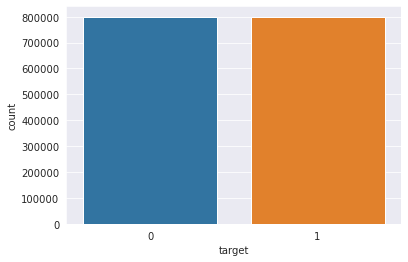

In [3]:
# show the distribution of labels
sns.countplot(comp_df.target)
plt.show()

In [4]:
# Remove all the unwanted elements in text
def format_text(df,col):
  #Remove @ tags
  comp_df = df.copy()
    
  # remove all the punctuation
  comp_df[col] = comp_df[col].str.replace(r'(@\w*)','')

  #Remove URL
  comp_df[col] = comp_df[col].str.replace(r"http\S+", "")

  #Remove # tag and the following words
  comp_df[col] = comp_df[col].str.replace(r'#\w+',"")

  #Remove all non-character
  comp_df[col] = comp_df[col].str.replace(r"[^a-zA-Z ]","")

  # Remove extra space
  comp_df[col] = comp_df[col].str.replace(r'( +)'," ")
  comp_df[col] = comp_df[col].str.strip()

  # Change to lowercase
  comp_df[col] = comp_df[col].str.lower()

  return comp_df

formated_comp_df = format_text(comp_df,'text')

# Drop the columns we don't want
formated_comp_df.drop(['id','date','flag','user'],axis=1,inplace=True)

In [5]:
formated_comp_df.head()

,target,text
0,0,awww thats a bummer you shoulda got david carr...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


In [6]:
# data size
formated_comp_df.shape[0]

1600000

# Visualize the words in word cloud

In [7]:
def show_wc(df,stopword=False):
    if stopword:
        stop_words = stopwords.words('english')
        wc = WordCloud(max_words=1000, background_color='white',stopwords=stop_words,colormap='rainbow',height=1000,width=700)
    else:
        wc = WordCloud(max_words=1000, background_color='white',colormap='rainbow',height=1000,width=700)
    text =df.text.values
    wc.generate(str(text))
    
    fig = plt.figure()
    plt.imshow(wc)
    fig.set_figwidth(10)
    fig.set_figheight(10)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

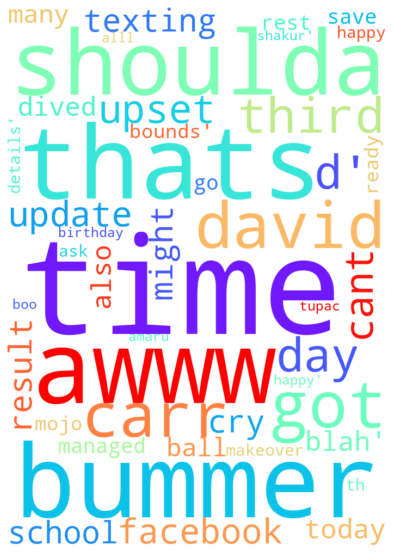

In [8]:
show_wc(formated_comp_df, stopword=True)

# Date preparation


- Split into training set and validation(test) set
- Lemmatize the words
- Tokenization: word -> number
- Word padding
- Transoform the dataset with batch size 256.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk import TweetTokenizer

In [10]:
tweet_tokenizer= TweetTokenizer(reduce_len=3)
formated_comp_df.text = formated_comp_df.text.apply(lambda x: tweet_tokenizer.tokenize(x))

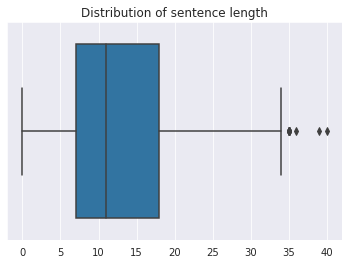

In [11]:
# See the distribution of sentence length 
sen_length = [len(x) for x in formated_comp_df.text.tolist()]
sns.boxplot(sen_length)
plt.title('Distribution of sentence length')
plt.show()

In [12]:
# Function for build text list
def word_list(dataframe,clear_stopwords=False):
  df = dataframe.copy()
    
  # lemmatize the word
  lemma = nltk.WordNetLemmatizer()
  df.text = df.text.apply(lambda x: [lemma.lemmatize(i) for i in x])
  if clear_stopwords:
    stop_words = stopwords.words('english')
    df.text = df.text.apply(lambda x: [i for i in x if not i in stop_words])
    
  # combined into a sentence again
  df.text = df.text.apply(lambda x: ' '.join(x))

  word_list = df.text.tolist()
  return word_list

# Tokenize and padding the text list
def token_padding(word_list, tokenizer,length,pad):
  sequences = tokenizer.texts_to_sequences(word_list)
  padding = pad_sequences(sequences, maxlen=length,padding=pad,truncating='post')
  return padding

In [42]:
# tokenize and padding
embedding_dim = 50 # since we will use 50d of Glove
max_length = 30
padding = 'post'
oov_tok = '<OOV>'
batch_size = 256
training_size = formated_comp_df.shape[0]
test_size = 10000 #number of samples for testing, not percentage
stop_words_clear = False

cropped_df = formated_comp_df.sample(training_size) #get the sample randomly from the original dataset

# Split the data into training and validation(test) set
x_train,x_val,y_train,y_val = train_test_split(cropped_df.drop('target',axis=1),cropped_df['target'],test_size=round(test_size/training_size,2))
x_train_list = word_list(x_train,clear_stopwords=stop_words_clear)
x_val_list = word_list(x_val,clear_stopwords=stop_words_clear)

# make tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_list)

x_train_pad = token_padding(x_train_list,tokenizer,max_length,padding)
x_val_pad = token_padding(x_val_list,tokenizer,max_length,padding)

train_set = tf.data.Dataset.from_tensor_slices((x_train_pad,np.array(y_train))).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices((x_val_pad,np.array(y_val))).batch(batch_size)

## Creating word embedding matrix

In [43]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
embeddings_index = {};

# Word embeddings with Glove6B 50D
# Add the glove6b 50D to the input data of kaggle before use it
with  open('../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt','r') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
        
# Build embedding matrix 
embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embeddings_matrix[i] = vector

# Setting up model


Model:
- Embedding layer
- 2 Bidirectional LSTM layers with 64 units.
- 2 Dense layers, 1 for output

Callbacks for Early stopping
- Track the training loss vs validation loss, if training loss is far lower than validation loss, the training is cancelled.

In [44]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import tensorflow.keras.regularizers as regularizers

In [45]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=()):
    train_loss = logs.get('loss')
    val_loss = logs.get('val_loss')
    if val_loss - train_loss > 0.2:
      print('Loss on validation set is much higher than training set. Training cancelled')
      self.model.stop_training=True


def build_model(vocab_size,embedding_dim,max_length):
  model = keras.models.Sequential([
          Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length,
                   weights=[embeddings_matrix],
                   trainable=False),
          Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)),
          Dropout(0.3),
          Bidirectional(LSTM(64,dropout=0.3)),
          Dropout(0.3),
          Dense(512,activation='relu'),
          Dropout(0.3),
          Dense(1,activation='sigmoid')])
      
  model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
  return model

In [46]:
num_epochs = 40
callbacks = myCallback()
model = build_model(vocab_size,embedding_dim,max_length)

# start training
history = model.fit(train_set,epochs=num_epochs,validation_data=(test_set),verbose=1,callbacks=[callbacks])

Epoch 1/40
6188/6188 [==============================] - 82s 13ms/step - loss: 0.5285 - acc: 0.7334 - val_loss: 0.4630 - val_acc: 0.7807
Epoch 2/40
6188/6188 [==============================] - 83s 13ms/step - loss: 0.4829 - acc: 0.7667 - val_loss: 0.4419 - val_acc: 0.7943
Epoch 3/40
6188/6188 [==============================] - 81s 13ms/step - loss: 0.4675 - acc: 0.7773 - val_loss: 0.4309 - val_acc: 0.7993
Epoch 4/40
6188/6188 [==============================] - 81s 13ms/step - loss: 0.4586 - acc: 0.7828 - val_loss: 0.4234 - val_acc: 0.8026
Epoch 5/40
6188/6188 [==============================] - 81s 13ms/step - loss: 0.4528 - acc: 0.7862 - val_loss: 0.4175 - val_acc: 0.8059
Epoch 6/40
6188/6188 [==============================] - 81s 13ms/step - loss: 0.4486 - acc: 0.7890 - val_loss: 0.4150 - val_acc: 0.8076
Epoch 7/40
6188/6188 [==============================] - 81s 13ms/step - loss: 0.4448 - acc: 0.7913 - val_loss: 0.4138 - val_acc: 0.8092
Epoch 8/40
6188/6188 [==========================

# Plotting the loss and accuracy

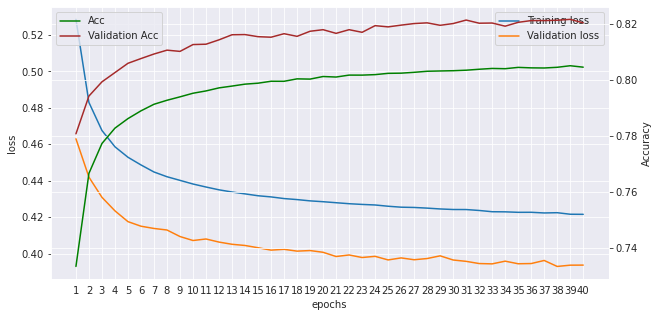

In [48]:
fig, (ax1) = plt.subplots(figsize=(10,5))
ax2 =ax1.twinx()

ax1.plot(range(1,num_epochs+1),history.history['loss'])
ax1.plot(range(1,num_epochs+1),history.history['val_loss'])

ax2.plot(range(1,num_epochs+1),history.history['acc'],color='green')
ax2.plot(range(1,num_epochs+1),history.history['val_acc'],color='brown')
plt.xticks(list(range(1,num_epochs+1,1)))

ax1.legend(['Training loss','Validation loss'])
ax2.legend(['Acc','Validation Acc'])

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.set_ylabel('Accuracy')

plt.show()

### Conlcusion

- According to the graph, the model is slightly underfitting, both loss of training set and loss of test set are still slightly decreasing while the loss of test set is lower than training set.

- 40 epochs seems not enough. Increase the number of epochs or use a larger learning rate would be helped.

Thank you